[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/assignments/library_searching/library_searching_asignment.ipynb)

# Docking and library searching assignment, PharmSci 175/275

### Submission by AK Nandkeolyar

## Objective
In this assignment you will perform one or more sample library searches to examine docking performance on a test set or test sets. This assignment will differ somewhat from the others in that it gives you more of a chance to explore.

## Overview
As discussed in class, docking methods are one of the fairly widely used computational methods for studying binding, and have seen significant applications in the area of virtual screening of libraries of potential ligands to filter out compounds which are unlikely to be active and hopefully increase the success rate of finding active compounds via experiments. These methods, while fairly fast, are still typically require a few seconds per compound or more, and thus often are unsuited for filtering large libraries of millions of compounds. In such cases, even faster methods such as LINGO searches may be used for pre-filtering.

Here, I am providing you with sample scripts to perform a test LINGO search to filter a library of several million compounds down to a smaller number which have similarity to a known ligand, then to dock these to a target receptor and look at enrichment of active compounds. The test case I have provided is binding of various small molecules to the LEDGF site of HIV-1 integrase, as seen in the 3D structure/shape assignment and as described in the SAMPL4 paper referenced below.

In this exercise, you will work through the example I provide, then perform tests of your own on at least three different data sets to see how well docking and LINGO searches will perform for you. You should also examine different scoring functions (within OpenEye’s docking toolkit). Think of this assignment as a bit of a sandbox - you are given some tools and a chance to play around. It is likely that the ideas you generate will help me make this assignment more successful the next time around, and any feedback is appreciated.

# Your assignment

Here, you will start off by doing a couple example activities so you can see how to use the OpenEye tools to do LINGO searches and docking. Once you’ve done these, then you will have the opportunity to branch out, try other things, and see what will work best on the system(s) you are looking at.

As background for this, I suggest you read, if you have not already done so, the paper on the [SAMPL4 HIV integrase challenge](http://dx.doi.org/10.1007/s10822-014-9723-5), as well as the [DUD paper](http://dx.doi.org/10.1021/jm0608356); the later [DUD-E paper](http://dx.doi.org/10.1021/jm300687e) may also be helpful.

Here, your warm-up work will relate to the HIV-1 integrase system studied in the SAMPL4 challenge (and seen in the 3D structure/shape assignment).

## Warm-up Part 1: Lingo search and other prep

Here, your task is to do a simple test of the Lingo search method by downloading a subset of the ZINC database, hiding some known integrase inhibitors in it, and testing the ability of the LINGO search method to enrich the database for known HIV-1 integrase inhibitors.

### First get some compounds to work with

As a starting point, let's get some compounds to work with. Visit the ZINC15 database (zinc15.docking.org), and click through on "Tranches" (subsets) towards the bottom left. This allows you to select all available compounds or subsets by purchaseability, molecular weight, calculated logP, etc. (You can toggle on and off rows and columns by clicking the top or left columns or rows), and filter by reaction likelihood (top menu) or wait time (top menu) and other properties. Select some subset of compounds (600 million is probably too many; let's keep it to a couple million or less) using these options. 

Once you've selected a subset (I filtered to get "clean" "in stock" compounds between 200-400 Daltons in some of the middle logP ranges) click the download buttom at the top right to pop up a "Download Tranches" menu. **Don't actually download**. Just copy the listed tranche codes; we can use those here to make your life easier.

Now paste your tranche codes into the box below as a string called `tranches`, like this:

## Installing Packages

***If you are running this on Google Colab, please add the installation blocks from the [getting started notebook](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/Getting_Started.ipynb) or [condacolab](https://github.com/aakankschit/drug-computing/blob/master/uci-pharmsci/Getting_Started_condacolab.ipynb) here and then execute the code below***

In [16]:
import urllib
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from openeye.oechem import *
from openeye import oedocking
from openeye import oeomega

Now we'll use the code below (using Python's `urllib` module) to download the files from these tranches and link them together into one big text file for further processing (so we don't have to download again if we need them again), and also save them to the list `zinc_compounds`. 

The file may be large. (e.g. I downloaded about 4.5 million compounds and ended up with a roughly 260 MB file; this could be reduced using compression but it's a lot of data regardless).

If you wanted to do an even larger number of compounds, you would probably want to process one tranche at a time rather than grouping them all up into one large set like I'm doing here. 

**You should just need to run this code**:

In [17]:
# Tranches. Replace these with your selected tranches
tranches = "EKAA EKAB EKBA EKBB EKCA EKCB EKEA EKEB FKAA FKAB FKBA FKBB FKCA FKCB FKEA FKEB GKAA GKAB GKBA GKBB GKCA GKCB GKEA GKEB"

In [ ]:
# Split up the string of tranches into a list
tranches_elements = tranches.split()

# Set up an output file and list for storing results
filename = 'zinc_compounds.smi'
out_file = open(filename, 'w')
zinc_compounds = []

# Loop over SMILES string files for desired tranches 
import urllib
for t_id in tranches_elements:
    prefix = t_id[0:2]
    # Retrieve file-like object for iterating over contents of this one
    contents = urllib.request.urlopen('http://files.docking.org/2D/' + prefix + '/'+ t_id +'.smi')
    # Loop over each line, decode from bytes format to string, write to output. Skip the first line of each file
    # which is a header line
    for line in contents:
        if line.split()[0].decode() != 'smiles':
            # Replace some special characters at the same time
            out_file.write(line.decode().replace('\n',''))
            zinc_compounds.append(line.decode().replace('\r\n',''))
            
out_file.close()

### Now retrieve the SAMPL4 compounds from a file

Next, you need to load the SAMPL4 compounds and insert them in your set. These are present in this directory as `SAMPL4_smiles.smi`. Both the ZINC data and the SAMPL4 data are in a format where the SMILES string is the first entry on each line and the compound ID or name is the second entry.

**Insert code below to read in the SAMPL4 compounds (stored in `sampl4_compounds`) and then make a new list called `all_compounds` which contains the ZINC compounds plus the SAMPL4 compounds**

In [5]:
# Your code goes here
with open('sampl4_smiles.smi', 'r') as file_in:
    sampl4_compounds = []
    for line in file_in:
        sampl4_compounds.append(line)
all_compounds = zinc_compounds + sampl4_compounds

### Let's also get a known integrase ligand for use as reference

`3NF8_ligand.pdb` in this directory contains a known HIV integrase ligand (from the 3NF8 structure in the PDB) which can be used as a query for trying to find other, similar integrase ligands, as we will do here. Using Python code or a 2D viewer, create a SMILES string for this ligand (recommended option: Use the OpenEye toolkits, read it in as an OEMol, and create an isomeric SMILES string for it) and save it into a plain text file named something like `query.smi`; this will serve as the query molecule for our LINGO search. You can also save it to a variable like `querymolecule_smiles` in this notebook.

**Your code for this goes here (if you use code) and make sure you end up with a `querymolecule_smiles` variable:**

In [50]:
querymolecule_smiles = 'CC[C@@H](C)NC(=O)c1ccccc1C[N@@H+](CC=C)Cc2ccc3c(c2C(=O)[O-])OC[C@@H](O3)CCC(=O)[O-]'

In [51]:
istream = oemolistream('3NF8_ligand.pdb')
mol = OEMol()
OEReadMolecule(istream,mol)
istream.close()

In [52]:
OECreateIsoSmiString(mol)

'c1cc2c(cc1Cl)CC(=O)N2Cc3ccc4c(c3C(=O)[O-])OCCO4'

### Update the code below to process your `all_compounds` list and filter it down to 10k compounds

Next, you'll process your set of compounds from ZINC (plus the known ligands you inserted) and compare to the reference molecule in `querymolecule_smiles`using the code below.

The code below currently takes in a `combined.smi` input file; you'll need to modify it to use your input (an `all_compounds` list).

In [56]:
from openeye.oechem import *
import pickle

#INFILE: Input file containing SMILES strings and titles of the molecules you want to examine
#infile = 'combined.smi'
#infile = all_compounds

#Query molecule: This assumes you already have `querymolecule_smiles` containing the SMILES string for your query molecule
#Load reference molecule
qmol = OEGraphMol()
OEParseSmiles( qmol, querymolecule_smiles )

#Initialize lingo comparison
lingo = OELingoSim( qmol )

#########################################################################
#Load other molecules and do the LINGO search to compute similarity scores
#########################################################################

#file = open( infile, 'r') #Open input file for reading
#text = file.readlines() #Read contents and close
#file.close()

#Initialize storage for results
sims_by_name = {}
smiles_by_name = {}
text=all_compounds
#Loop over the text we read in and do similarity comparison
for (idx,line) in enumerate(text):

    #Every 1000 molecules, print an update on progress.
    #if idx%1000==0:
        #print("%s/%s" % (idx, len(text) ))

    #Extract data - split the line up into components
    tmp = line.split()

    #Initialize new, empty molecule
    mol = OEGraphMol()
    #Read SMILES into molecule from first entry on line read from file
    OEParseSmiles( mol, tmp[0] )
    
        #DO similarity comparison via lingo
    sim = lingo.Similarity( mol )

    #Load and score smiles string and name for future reference.
    smi = tmp[0]
    name = tmp[1]
    sims_by_name[ name ] = sim
    smiles_by_name[name] = smi

#########################################################################
#Process results, print out info, store results.
#########################################################################

#Get lists of similarities and compound names.
similarities = list(sims_by_name.values())
names = list(sims_by_name.keys())
print(len(names))

#Do a sort of the names by similarity score, highest to lowest.
names = sorted(names, key=lambda name: -sims_by_name[name])

#Print out maximum similarity score
#print("Max similarity: %.3f" % max(similarities))

#Save top 10,000 most similar compounds (the full set is probably too large to save again) to a pickle file in case we want to re-load them to do anything else with them.
saveNum = 10000
smiles = [ smiles_by_name[name] for name in names[0:saveNum] ]
file = open('match_names_and_smiles.pickle', 'wb')
pickle.dump((names, smiles), file)
file.close()

#Save 1,000 most similar componds (again, full set is too large) to a plain text file, AND print out info on them..
file = open('match_names_and_smiles.txt', 'w')
print("Molecules, most similar to least similar:")
for n in range(saveNum):
    #Store top (saveNum) most similar molecules.
    name = names[n]
    #print('%s \t %s' % (name, sims_by_name[name]))
    file.write('%s\t %s \t %s\n' % ( smiles_by_name[name], names[n], sims_by_name[name]))
file.close()

1960642
Molecules, most similar to least similar:


### Check how well your Lingo search did at finding the known active compounds

The script above writes the top 10,000 matches to a pickle file and a text file. Check how many of the known active compounds (from `sampl4_compounds`) are in the top 10,000. Specifically, write a python script which:
- Takes the top 10,000 Lingo matches
- Checks their names against the actives in `sampl4_compounds`
- Calcluate the enrichment factor for this 10,000 compounds (the number of actives you actually found, divided by the number you would expect to find if you were guessing randomly and the Lingo search were doing no good (so that active compounds were divided randomly throughout the full set).

You may wish to also use `oenotebook` to depict some of your top compounds and see how they compare to the actual actives. 

Ask for help if these tasks seem challenging. 

**Your python code for this should go here**:

In [93]:
file = open('match_names_and_smiles.txt', 'r')
text = file.readlines()
file.close()

# Creates a Dictionary of SMILE strings 
mol_by_name = {}
for line in text:
    tmp = line.split()
    name=tmp[1]
    smiles=tmp[0]
    mol_by_name[name] = smiles

#Load actual binders
file = open('SAMPL4_smiles.smi', 'r')
text = file.readlines()
file.close()
binders=[]
for line in text:
    smiles=line.split()[1]
    binders.append(smiles)

In [94]:
score=0
scores=0
enrichment_scores = []
i=0
ranks = []
for key in mol_by_name:
    i+=1
    ranks.append(i)
    if key in binders:
        scores+=1
        enrichment_scores.append(scores)
    else:
        enrichment_scores.append(scores)
Fraction_of_binders = [enrichment_score/len(binders) for enrichment_score in enrichment_scores]              

In [96]:
print(binders)

['AVX38779_0', 'AVX101124_1', 'AVX101118_1', 'AVX38783_1', 'AVX17558_3', 'AVX38782_1', 'AVX17260_0', 'AVX17680_0', 'AVX101121_0', 'AVX17557_3', 'AVX101122_1', 'AVX38785_1', 'AVX38672_0', 'AVX17556_3', 'AVX17377_0', 'AVX38780_0', 'AVX38708_1', 'AVX38747_0', 'GL5243102_0', 'AVX17557_2', 'AVX40911_0', 'AVX38749_0', 'AVX38787_1', 'GL5243104_0', 'AVX17542_0', 'AVX17257_0', 'AVX38748_0', 'AVX38786_1', 'AVX17375_2', 'GL5243106_0', 'AVX15988_0', 'AVX40812_0', 'AVX101140_0', 'AVX101119_0', 'AVX38743_5', 'AVX17389_0', 'GL5243100_0', 'AVX17379_0', 'AVX17715_0', 'AVX38741_1', 'AVX38742_3', 'AVX17287_0', 'AVX40811_0', 'AVX38753_3', 'AVX38674_0', 'AVX17286_0', 'AVX38784_5', 'AVX17560_0', 'AVX38789_1', 'AVX17631_0', 'AVX38673_1', 'pC2A03_0', 'AVX17679_0', 'AVX17285_0', 'AVX38781_1', 'AVX38788_1']


In [20]:
import numpy as np
random_actives = np.linspace(0,0.6,len(Fraction_of_binders))

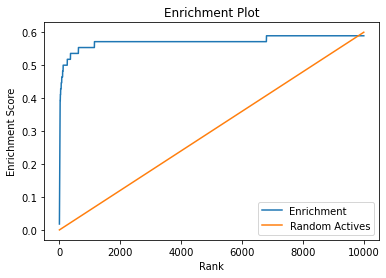

In [21]:
import matplotlib.pyplot as plt
fig1,ax1 = plt.subplots()
ax1.plot(ranks,Fraction_of_binders,label='Enrichment')
ax1.plot(ranks,random_actives,label='Random Actives')
plt.xlabel("Rank")
plt.ylabel("Enrichment Score")
plt.title("Enrichment Plot")
plt.legend(loc="lower right")

## Warm-up Part 2: Docking

In this section, your starting point is rather similar to that in the section above — but this time, since docking is a lot slower than a LINGO search, let’s just see how simple docking can do at picking out SAMPL4 active compounds from a larger set of nonbinders. This directory contains a file called `Maybridge_nonbinders.smi`, which is non-binders from a set of fragments Tom Peat and his collaborators experimentally screened initially in SAMPL4 (which led to the lead series found in `SAMPL4_smiles.smi`). This directory also contains `3NF8_prepped.pdb`, the receptor, and `3NF8_ligand.pdb`, a reference ligand from that structure.


Also get a copy of `dock_example.py` from there, a docking tool based on an example from the OpenEye documentation, and `get_scores_from_sdf.py`, a rough Python script for analyzing the output and making an enrichment plot.

### Read in the relevant data

Read in the `Maybridge_nonbinders.smi` and `SAMPL4_smiles.smi` into a single list of lines similary to what was done above, so you have a list of compounds to dock here (we'll be docking both active and inactive compounds and seeing how well we can do at recognizing the actives). Store these into separate lists, then make a combined list of both that's called `all_docking_compounds`.

**Insert your code for this here**:

In [10]:
with open('Maybridge_nonbinders.smi', 'r') as file_in:
    Maybridge_compounds = []
    for line in file_in:
        Maybridge_compounds.append(line)
all_docking_compounds = Maybridge_compounds + sampl4_compounds

### Now dock using the compounds using the code below.

The code below will use the `Chemgauss4` scoring function from the OpenEye toolkits to dock your compounds to the target. You should try it out; you may also want to revisit it later and consider testing alternate scoring functions [described in the OpenEye documentation](https://docs.eyesopen.com/toolkits/python/dockingtk/docking.html) such as the Hybrid2, PLP, or Chemscore scoring functions. `Hybrid2` is particularly interesting as it is a combination of docking and shape comparison and could perform particularly well here since we have both the receptor AND a known ligand we can use. Comparing performance of these methods would be a useful outcome of this exercise.

This draws on code you saw in the docking sandbox.

#### Prep your receptor for docking

In [11]:
from openeye import oedocking
from openeye import oeomega
from openeye import oechem

# Load the HIV integrase receptor from disk
imstr = oemolistream('3NF8_prepped.pdb')
protein = oechem.OEGraphMol()
oechem.OEReadMolecule(imstr, protein)
imstr.close()

# Load a reference ligand; we'll use this to indicate where the binding site is (and for `Hybrid`, it serves as a reference ligand)
ligand = oechem.OEGraphMol()
imstr = oechem.oemolistream('3NF8_ligand.pdb')
oechem.OEReadMolecule(imstr, ligand)
imstr.close()

# Initialize the receptor for docking
receptor = oechem.OEGraphMol()
oedocking.OEMakeReceptor(receptor, protein, ligand)

True

#### Choose your docking scoring function

If you wish to test other scoring functions, this would be where you would change it

In [24]:
#Set the docking method and docking resolution
# Note: Chemgauss4 is the scoring function for FRED
dock_method = oedocking.OEDockMethod_Chemgauss4
dock_resolution = oedocking.OESearchResolution_Default
sdtag = oedocking.OEDockMethodGetName( dock_method )

#Generate our OEDocking object
dock = oedocking.OEDock( dock_method, dock_resolution)

#Initialize the OEDocking by providing it the receptor
if not dock.Initialize(receptor):
    # raise an exception if the receptor cannot be initialized
    raise Exception("Unable to initialize Docking with {0}".format(self.args.receptor))

#### Define a function for docking

In [25]:
def dock_molecule( dock: "OEDock", sdtag: str, num_poses: int, mcmol ) -> tuple:
    ''' Docks the multiconfomer molecule, with the given number of poses
        Returns a tuple of the docked molecule (dockedMol) and its score
        i.e. ( dockedMol, score )
    '''
    dockedMol = oechem.OEMol()

    #Dock the molecule into a given number of poses
    res = dock.DockMultiConformerMolecule(dockedMol, mcmol, num_poses)
    
    if res == oedocking.OEDockingReturnCode_Success:
        
        #Annotate the molecule with the score and SDTag that contains the docking method
        oedocking.OESetSDScore(dockedMol, dock, sdtag)
        dock.AnnotatePose(dockedMol)
        score = dock.ScoreLigand(dockedMol)
        oechem.OESetSDData(dockedMol, sdtag, "{}".format(score))
        return dockedMol, score
    
    else:
        # raise an exception if the docking is not successful
        raise Exception("Unable to dock ligand {0} to receptor".format( dockedMol ))

#### Run docking

Note that this assumes your ligand SMILES and names are stored in `all_docking_compounds`.

You shouldn't have to change settings here, but you can if you like; e.g. for testing purposes you might wish to dock just a subset of the compounds.

In [ ]:
omega = oeomega.OEOmega()
omega.SetStrictStereo(False) 

# Generate conformers for compounds and dock
inmols = []
usednames = []
for idx,line in enumerate(all_docking_compounds):
    tmp = line.split()
    smi = tmp[0]
    mol = oechem.OEMol()
    name = tmp[1]
    if name=='' or name==None or len(name)<3:
        #Define alternate name based on index
        name = 'mol%s smiles %s' % (idx, smi)
        print("No name found on line %s; using alternate name %s..." % (idx, name))
    if not name in usednames: #Make sure haven't already used this one
        usednames.append(name)
        oechem.OEParseSmiles(mol, smi)
        mol.SetTitle(name)
        builtOK = omega(mol)
        inmols.append(mol)
    else:
        continue

#Define how many docked poses to generate per molecule
num_poses = 2


#Open a filestream for writing the docked molecules
scores = {}
with oechem.oemolostream( 'dock-results.sdf') as ofs:

    #Loop over 3D molecules from the input filestream
    for mcmol in inmols:

        #Call our written docking function
        dockedMol, score = dock_molecule( dock, sdtag, num_poses, mcmol )
        print("{} {} score = {:.4f}".format(sdtag, dockedMol.GetTitle(), score))

        #Write docked molecules to output filestream
        oechem.OEWriteMolecule(ofs, dockedMol)
        
        # Store score
        scores[ mcmol.GetTitle()] = score


Here, `dock-results.sdf` is a key output file. This is a structure file (sdf) and will contain 3D poses of molecules docked into the receptor, along with scores. You can visualize these by loading them into PyMol or a similar viewer (e.g. Vida, VMD, Chimera, ...) along with the receptor (`3NF8_prepped.pdb`).

### Now let's do an enrichment plot

If we needed to use the scores stored to file, we would start by retrieving them from the SDF file they're stored in. But we already have them in `scores`, which is a dictionary storing scores by molecule title. So here, our first step is to load active compounds and check which ones are present among our docked compounds, at which ranks.

You should be able to just run this code:

In [ ]:
# Read active compounds
active_smiles_by_name = {}
file = open('SAMPL4_smiles.smi', 'r')
text = file.readlines()
file.close()
for line in text:
    tmp = line.split()
    active_smiles_by_name[tmp[1]] = tmp[0]

# Build list of titles sorted by score
sorted_titles = list(scores.keys())
sorted_titles.sort( key = lambda title: scores[title] )

# Count how many actives are found at which ranks
ct = 0
fnd_actives = []
for active_name in active_smiles_by_name.keys():
    if active_name in sorted_titles:
        ct += 1
        print("Active %s found in docking results at rank %s" % ( active_name, sorted_titles.index(active_name)))
        fnd_actives.append( active_name )

print("Total compounds: %s" % len(sorted_titles))

#Find number of actives
n_actives = len(fnd_actives)

The next step is to actually generate an enrichment plot. This does a really basic one, which it should display inline AND save to a PDF file:

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/drug_comp/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['Text', 'Arrow', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


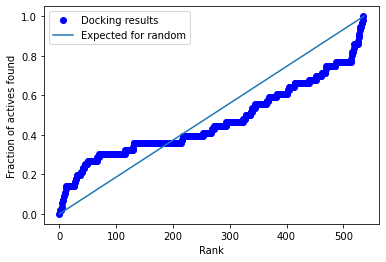

<Figure size 432x288 with 0 Axes>

In [28]:
#Do an enrichment plot
%pylab inline
numfound = []
ct=0
for name in sorted_titles:
    if name in active_smiles_by_name.keys():
        ct+=1
    numfound.append(ct)
fracfound = [ ct/float(n_actives) for ct in numfound]
plot( arange(len(sorted_titles)), fracfound, 'bo')
plot( [0, len(sorted_titles)], [0, 1]) #Random line
legend(('Docking results', 'Expected for random'))
xlabel('Rank')
ylabel('Fraction of actives found')
show()

## Hybrid Method Run for Example

In [15]:
#Set the docking method and docking resolution
# Note: Chemgauss4 is the scoring function for FRED
dock_method = oedocking.OEDockMethod_Hybrid
dock_resolution = oedocking.OESearchResolution_Default
sdtag = oedocking.OEDockMethodGetName( dock_method )

#Generate our OEDocking object
dock = oedocking.OEDock( dock_method, dock_resolution)

#Initialize the OEDocking by providing it the receptor
if not dock.Initialize(receptor):
    # raise an exception if the receptor cannot be initialized
    raise Exception("Unable to initialize Docking with {0}".format(self.args.receptor))

In [18]:
def dock_molecule( dock: "OEDock", sdtag: str, num_poses: int, mcmol ) -> tuple:
    ''' Docks the multiconfomer molecule, with the given number of poses
        Returns a tuple of the docked molecule (dockedMol) and its score
        i.e. ( dockedMol, score )
    '''
    dockedMol = oechem.OEMol()

    #Dock the molecule into a given number of poses
    res = dock.DockMultiConformerMolecule(dockedMol, mcmol, num_poses)
    
    if res == oedocking.OEDockingReturnCode_Success:
        
        #Annotate the molecule with the score and SDTag that contains the docking method
        oedocking.OESetSDScore(dockedMol, dock, sdtag)
        dock.AnnotatePose(dockedMol)
        score = dock.ScoreLigand(dockedMol)
        oechem.OESetSDData(dockedMol, sdtag, "{}".format(score))
        return dockedMol, score
    
    else:
        # raise an exception if the docking is not successful
        raise Exception("Unable to dock ligand {0} to receptor".format( dockedMol ))

In [ ]:
omega = oeomega.OEOmega()
omega.SetStrictStereo(False) 

# Generate conformers for compounds and dock
inmols = []
usednames = []
for idx,line in enumerate(all_docking_compounds):
    tmp = line.split()
    smi = tmp[0]
    mol = oechem.OEMol()
    name = tmp[1]
    if name=='' or name==None or len(name)<3:
        #Define alternate name based on index
        name = 'mol%s smiles %s' % (idx, smi)
        print("No name found on line %s; using alternate name %s..." % (idx, name))
    if not name in usednames: #Make sure haven't already used this one
        usednames.append(name)
        oechem.OEParseSmiles(mol, smi)
        mol.SetTitle(name)
        builtOK = omega(mol)
        inmols.append(mol)
    else:
        continue

#Define how many docked poses to generate per molecule
num_poses = 2


#Open a filestream for writing the docked molecules
scores = {}
with oechem.oemolostream( 'dock-results.sdf') as ofs:

    #Loop over 3D molecules from the input filestream
    for mcmol in inmols:

        #Call our written docking function
        dockedMol, score = dock_molecule( dock, sdtag, num_poses, mcmol )
        print("{} {} score = {:.4f}".format(sdtag, dockedMol.GetTitle(), score))

        #Write docked molecules to output filestream
        oechem.OEWriteMolecule(ofs, dockedMol)
        
        # Store score
        scores[ mcmol.GetTitle()] = score


In [ ]:
# Read active compounds
active_smiles_by_name = {}
file = open('SAMPL4_smiles.smi', 'r')
text = file.readlines()
file.close()
for line in text:
    tmp = line.split()
    active_smiles_by_name[tmp[1]] = tmp[0]

# Build list of titles sorted by score
sorted_titles = list(scores.keys())
sorted_titles.sort( key = lambda title: scores[title] )

# Count how many actives are found at which ranks
ct = 0
fnd_actives = []
for active_name in active_smiles_by_name.keys():
    if active_name in sorted_titles:
        ct += 1
        print("Active %s found in docking results at rank %s" % ( active_name, sorted_titles.index(active_name)))
        fnd_actives.append( active_name )

print("Total compounds: %s" % len(sorted_titles))

#Find number of actives
n_actives = len(fnd_actives)

Populating the interactive namespace from numpy and matplotlib


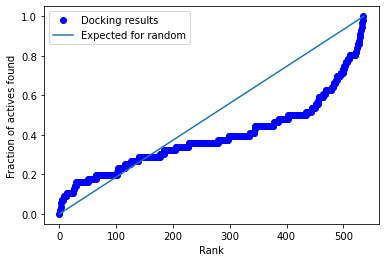

<Figure size 432x288 with 0 Axes>

In [22]:
#Do an enrichment plot
%pylab inline
numfound = []
ct=0
for name in sorted_titles:
    if name in active_smiles_by_name.keys():
        ct+=1
    numfound.append(ct)
fracfound = [ ct/float(n_actives) for ct in numfound]
plot( arange(len(sorted_titles)), fracfound, 'bo')
plot( [0, len(sorted_titles)], [0, 1]) #Random line
legend(('Docking results', 'Expected for random'))
xlabel('Rank')
ylabel('Fraction of actives found')
show()

## Sandbox: Try out some other things

For the final programming part of this assignment, you have the opportunity to try out some other things *of your choice* which relate to the topic. For example, you might consider linking the two tests above -- if you dock the results of a LINGO search, how well can docking do at further enriching the active compounds? 

You also might be interested in getting the DUD-E set's HIV integrase ligands (actives) and decoys (nonbinders) -- this provides a second set of actual integrase binders which are fairly distinct from the series represented by the 3NF8 ligand (see http://dude.docking.org/targets). You could experiment to see whether docking and/or lingo searches can recognize the DUD-E integrase ligands out of the DUD-E integrase decoys, or out of ALL non-binders from DUD-E, or even whether it can recognize DUD-E integrase ligands hidden in a subset of ZINC. Experimenting here would give you a sense of how the performance of these methods depends on the dataset you are using.

You could likewise take any of the other ligand+decoy sets from DUD-E and evaluate docking and/or LINGO performance on those. 

You are free to try a variety of things, but **your final submission should include your results on at least three different datasets, and you should look at several different scoring functions. You should provide enrichment plots for every different system and scoring function examined.** Unlike some of our other assignments, relatively minimal coding is required here - mostly you’re just running things I’ve provided for you - so you should take some more time to examine the results. 

# Functions

Given that I am going to have to re-use a lot of code blocks multiple times, I have modified them to be compatible with custom built data frames that I creating from data retrieved from the DUD-E database. Please see below for the structure of the data frames.

## Lingo Search Function

Writes a `.txt` called `txt_file_name` file that contains the 1000 similar compounds, also writes a `.pickle` called `pickle_file_name` that contains 10,000 compounds. It should be noted that the names should be input with `.txt` and `.pickle` extensions.

In [38]:
def lingo_search(df_smiles_names,pickle_file_name,text_file_name,querymolecule_smiles):
    #Query molecule: This assumes you already have `querymolecule_smiles` containing the SMILES string for your query molecule
    #Load reference molecule
    qmol = OEGraphMol()
    OEParseSmiles( qmol, querymolecule_smiles )

    #Initialize lingo comparison
    lingo = OELingoSim( qmol )

    #########################################################################
    #Load other molecules and do the LINGO search to compute similarity scores
    #########################################################################

    #Initialize storage for results
    sims_by_name = {}
    smiles_by_name = {}
    #Loop over the text we read in and do similarity comparison
    for idx,line in df_smiles_names.iterrows():

        #Initialize new, empty molecule
        mol = OEGraphMol()
        #Read SMILES into molecule from first entry on line read from file
        OEParseSmiles( mol, line['smiles'] )

            #DO similarity comparison via lingo
        sim = lingo.Similarity( mol )

        #Load and score smiles string and name for future reference.
        smi = line['smiles']
        name = line['names']
        sims_by_name[ name ] = sim
        smiles_by_name[name] = smi

    #########################################################################
    #Process results, print out info, store results.
    #########################################################################

    #Get lists of similarities and compound names.
    similarities = list(sims_by_name.values())
    names = list(sims_by_name.keys())
    print(len(names))

    #Do a sort of the names by similarity score, highest to lowest.
    names = sorted(names, key=lambda name: -sims_by_name[name])

    #Print out maximum similarity score
    #print("Max similarity: %.3f" % max(similarities))

    #Save top 10,000 most similar compounds (the full set is probably too large to save again) to a pickle file in case we want to re-load them to do anything else with them.
    saveNum = 10000
    smiles = [ smiles_by_name[name] for name in names[0:saveNum] ]
    file = open(pickle_file_name, 'wb')
    pickle.dump((names, smiles), file)
    file.close()

    #Save 1,000 most similar componds (again, full set is too large) to a plain text file, AND print out info on them..
    file = open(text_file_name, 'w')
    #print("Molecules, most similar to least similar:")
    for n in range(0,1000):
        #Store top (saveNum) most similar molecules.
        name = names[n]
        #print('%s \t %s' % (name, sims_by_name[name]))
        file.write('%s\t %s \t %s\n' % ( smiles_by_name[name], names[n], sims_by_name[name]))
    file.close()


## Lingo Search Enrichment Scoring Function

Reads the `.txt` file containing the 1000 compounds as well as the text file that contains the list of actives. Returns an enrichment score and ranks associated as a `pandas Data-Frame`.

In [30]:
def get_enrichment_score(all_compounds_txt_file,actives_txt_file):
    
    ## Load Data
    all_compounds = pd.read_csv(all_compounds_txt_file,sep=" ",header=None)
    all_compounds.columns = ['SMILES','Names','No','Sims']
    all_compounds = all_compounds.drop(['No'],axis=1)
    all_actives = pd.read_csv(actives_txt_file,sep=" ",header=None)
    all_actives.columns = ['SMILES','No','Names']
    all_actives = all_actives.drop(['No'],axis=1)
    
    # Creates a Dictionary of SMILE strings 
    mol_by_name = {}
    for idx,rows in all_compounds.iterrows():
        name=rows['Names']
        smiles=rows['SMILES']
        mol_by_name[name] = smiles
    binders=[]
    for idx,rows in all_actives.iterrows():
        names=rows['Names']
        binders.append(names)
    
    # Enrichment Score Calculation
    scores = 0
    i=0
    enrichment_scores = []
    ranks = []
    for key in mol_by_name:
        i+=1
        ranks.append(i)
        if key in binders:
            scores+=1
            enrichment_scores.append(scores)
        else:
            enrichment_scores.append(scores)
            
    Fraction_of_binders = [enrichment_score/len(binders) for enrichment_score in enrichment_scores] 
    df_binders = pd.DataFrame()
    df_binders['ranks'] = ranks
    df_binders['Fraction_of_binders'] = Fraction_of_binders
    df_binders['Random_Actives']=np.linspace(0,0.6,len(Fraction_of_binders))
    
    
    return df_binders

## Docking Function

Takes an input of `receptor pdb file`, `ligand pdb file`, a string `docking Method`,a `data-frame of the SMILES and compound Names`,a string for naming the results file `results.sdf` and the list of actives as either an `.ism` file or a `dictionary`. Provides the fraction of bound ligands `fracfound` and the sorted names of the ligands `sorted_titles`.

In [70]:
def docking(receptor_file,ligand_file,docking_method,df_compounds,docking_results_file,list_of_actives_file):
    from openeye import oedocking
    from openeye import oeomega
    from openeye import oechem
    imstr = oemolistream(receptor_file)
    protein = oechem.OEGraphMol()
    oechem.OEReadMolecule(imstr, protein)
    imstr.close()

    # Load a reference ligand; we'll use this to indicate where the binding site is (and for `Hybrid`, it serves as a reference ligand)
    ligand = oechem.OEGraphMol()
    imstr = oechem.oemolistream(ligand_file)
    oechem.OEReadMolecule(imstr, ligand)
    imstr.close()

    # Initialize the receptor for docking
    receptor = oechem.OEGraphMol()
    oedocking.OEMakeReceptor(receptor, protein, ligand)
    
    # Use appropriate Docking Method
    
    if docking_method=='Fred':
        dock_method = oedocking.OEDockMethod_Chemgauss4
    elif docking_method=='Hybrid':
        dock_method = oedocking.OEDockMethod_Hybrid
    dock_resolution = oedocking.OESearchResolution_Default
    sdtag = oedocking.OEDockMethodGetName( dock_method )

    #Generate our OEDocking object
    dock = oedocking.OEDock( dock_method, dock_resolution)

    #Initialize the OEDocking by providing it the receptor
    if not dock.Initialize(receptor):
        # raise an exception if the receptor cannot be initialized
        raise Exception("Unable to initialize Docking with {0}".format(self.args.receptor))
        
    def dock_molecule( dock: "OEDock", sdtag: str, num_poses: int, mcmol ) -> tuple:
        ''' Docks the multiconfomer molecule, with the given number of poses
            Returns a tuple of the docked molecule (dockedMol) and its score
            i.e. ( dockedMol, score )
        '''
        dockedMol = oechem.OEMol()

        #Dock the molecule into a given number of poses
        res = dock.DockMultiConformerMolecule(dockedMol, mcmol, num_poses)

        if res == oedocking.OEDockingReturnCode_Success:

            #Annotate the molecule with the score and SDTag that contains the docking method
            oedocking.OESetSDScore(dockedMol, dock, sdtag)
            dock.AnnotatePose(dockedMol)
            score = dock.ScoreLigand(dockedMol)
            oechem.OESetSDData(dockedMol, sdtag, "{}".format(score))
            return dockedMol, score

        else:
            # raise an exception if the docking is not successful
            raise Exception("Unable to dock ligand {0} to receptor".format( dockedMol ))
            
    # G
    omega = oeomega.OEOmega()
    omega.SetMaxConfs(10)
    omega.SetStrictStereo(False)
    omega.SetStrictAtomTypes(False)

    # Generate conformers for compounds and dock
    inmols = []
    usednames = []
    for idx,line in df_compounds.iterrows():
        smi = line['smiles']
        mol = oechem.OEMol()
        name = line['names']
        if name=='' or name==None or len(name)<3:
            #Define alternate name based on index
            name = 'mol%s smiles %s' % (idx, smi)
            print("No name found on line %s; using alternate name %s..." % (idx, name))
        if not name in usednames: #Make sure haven't already used this one
            usednames.append(name)
            oechem.OEParseSmiles(mol, smi)
            mol.SetTitle(name)
            builtOK = omega(mol)
            inmols.append(mol)
        else:
            continue

    #Define how many docked poses to generate per molecule
    num_poses = 2


    #Open a filestream for writing the docked molecules
    scores = {}
    with oechem.oemolostream( docking_results_file) as ofs:

        #Loop over 3D molecules from the input filestream
        for mcmol in inmols:

            #Call our written docking function
            dockedMol, score = dock_molecule( dock, sdtag, num_poses, mcmol )
            #print("{} {} score = {:.4f}".format(sdtag, dockedMol.GetTitle(), score))

            #Write docked molecules to output filestream
            oechem.OEWriteMolecule(ofs, dockedMol)

            # Store score
            scores[ mcmol.GetTitle()] = score
    if type(list_of_actives_file)==str:
        active_smiles_by_name = {}
        file = open(list_of_actives_file, 'r')
        text = file.readlines()
        file.close()
        for line in text:
            tmp = line.split()
            active_smiles_by_name[tmp[2]] = tmp[0]
    else:
        active_smiles_by_name=list_of_actives_file

    # Build list of titles sorted by score
    sorted_titles = list(scores.keys())
    sorted_titles.sort( key = lambda title: scores[title] )

    # Count how many actives are found at which ranks
    ct = 0
    fnd_actives = []
    for active_name in active_smiles_by_name.keys():
        if active_name in sorted_titles:
            ct += 1
            #print("Active %s found in docking results at rank %s" % ( active_name, sorted_titles.index(active_name)))
            fnd_actives.append( active_name )

    #print("Total compounds: %s" % len(sorted_titles))

    #Find number of actives
    n_actives = len(fnd_actives)
    
    numfound = []
    ct=0
    for name in sorted_titles:
        if name in active_smiles_by_name.keys():
            ct+=1
        numfound.append(ct)
    fracfound = [ ct/float(n_actives) for ct in numfound]
    
    return fracfound,sorted_titles     

# DUD-E HIV Integrase Example
 Data taken from the DUD-E database for HIV integrase inhibitors. Code Cells below are used to prepare data.

In [25]:
# Your code goes here
with open('./hivint/actives_final.ism', 'r') as file_in:
    actives_names = []
    actives_smiles=[]
    for line in file_in:
        smiles = line.split(' ')[0]
        name = line.split(' ')[2]
        names = name.strip('\n')
        actives_names.append(names)
        actives_smiles.append(smiles)

In [26]:
with open('./hivint/decoys_final.ism', 'r') as file_in:
    decoys_names = []
    decoys_smiles=[]
    for line in file_in:
        smiles = line.split(' ')[0]
        name = line.split(' ')[1]
        names = name.strip('\n')
        decoys_names.append(names)
        decoys_smiles.append(smiles)

In [44]:
dt_hivintegrase = pd.DataFrame()
dt_hivintegrase['names'] = actives_names+decoys_names
dt_hivintegrase['smiles'] =  actives_smiles+decoys_smiles

In [45]:
print(dt_hivintegrase)

             names                                             smiles
0     CHEMBL414850  Oc3c(C(=O)NCc1ccc(F)cc1)nc(N2CCCCS2(=O)=O)c4cc...
1     CHEMBL198001     OC(=O)C(=O)\C=C(/O)c2cn(Cc1ccc(F)cc1)c3ccccc23
2     CHEMBL196391  COc3ccc2n(Cc1ccc(F)cc1)cc(C(/O)=C/C(=O)C(O)=O)...
3     CHEMBL210234  CN(C(=O)C(=O)N1CCCCC1)c3nc(C(=O)NCc2ccc(F)cc2)...
4     CHEMBL212412   COc4c2c(C(=O)N(Cc1ccc(F)cc1)C23CC3)c(O)c5ncccc45
...            ...                                                ...
6745     C66584685        Cc1cc(ccc1[N-]S(=O)(=O)CC(C)C)C(=O)N2CCSCC2
6746     C66587368  c1cc(cc(c1)S(=O)(=O)C(F)F)[N-]S(=O)(=O)c2ccc(c...
6747     C66855710    CCN(C1CCN(CC1)C(=O)Cc2c(nc(s2)[S-])C)S(=O)(=O)C
6748     C67003519    C[C@H](CSC)/C(=N/S(=O)(=O)N1CCc2c(ccs2)C1)/[O-]
6749     C67634897   CCO[C@H]1C[C@H]1/C(=N/S(=O)(=O)c2cccc(c2)I)/[O-]

[6750 rows x 2 columns]


## Lingo Search HIV Int

In [46]:
istream = oemolistream('./hivint/crystal_ligand.mol2')
mol = OEMol()
OEReadMolecule(istream,mol)
istream.close()
query_molecule = OECreateIsoSmiString(mol)

In [47]:
lingo_search(dt_hivintegrase,'hivintegrase_dude.pickle','hivintegrase_dude.txt',query_molecule)
df_hivintegrase_lingo_enrivhment = get_enrichment_score('hivintegrase_dude.txt','./hivint/actives_final.ism')

6745


In [48]:
print(df_hivintegrase_lingo_enrivhment)

     ranks  Fraction_of_binders  Random_Actives
0        1                 0.00        0.000000
1        2                 0.00        0.000601
2        3                 0.00        0.001201
3        4                 0.00        0.001802
4        5                 0.00        0.002402
..     ...                  ...             ...
995    996                 0.09        0.597598
996    997                 0.09        0.598198
997    998                 0.10        0.598799
998    999                 0.10        0.599399
999   1000                 0.10        0.600000

[1000 rows x 3 columns]


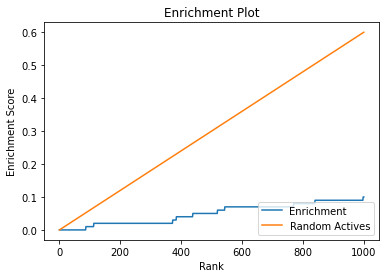

In [49]:
import matplotlib.pyplot as plt
fig1,ax1 = plt.subplots()
ax1.plot(df_hivintegrase_lingo_enrivhment['ranks'],df_hivintegrase_lingo_enrivhment['Fraction_of_binders'],label='Enrichment')
ax1.plot(df_hivintegrase_lingo_enrivhment['ranks'],df_hivintegrase_lingo_enrivhment['Random_Actives'],label='Random Actives')
plt.xlabel("Rank")
plt.ylabel("Enrichment Score")
plt.title("Enrichment Plot")
plt.legend(loc="lower right")

In [64]:
new_actives={}
names_lingo=[]
smiles_lingo=[]
dt_hivint_lingo = pd.DataFrame(columns=['names','smiles'])
with open('hivintegrase_dude.txt') as file:
    for line in file:
        names = line.split()[1]
        smiles = line.split()[0]
        names_lingo.append(names)
        smiles_lingo.append(smiles)
        if names in actives_names:
            new_actives[names]=smiles
dt_hivint_lingo['names'] = names_lingo
dt_hivint_lingo['smiles']=smiles_lingo

In [65]:
print(dt_hivint_lingo)

            names                                             smiles
0       C62827971            Cc1c(sc(c1C(=O)[O-])NC(=O)Nc2cccnc2Cl)C
1       C24768587  c1ccc2c(c1)CC[C@]23C(=O)N(C(=O)N3)CC(=O)Nc4cc5...
2       C36990827            c1ccc2c(c1)CC(C2)Nc3cc4c(cc3Cl)NC(=O)C4
3       C02901296  c1cc2c(cc1CC[NH2+]Cc3cc4c(cc3[N+](=O)[O-])OCO4...
4       C13449416  c1cc2c(cc1C(=O)[O-])CCN2C(=O)C3CCN(CC3)S(=O)(=...
..            ...                                                ...
995     C66091551  COC(CN1C(=O)C(=C([C@]12c3ccccc3NC2=O)C(=O)c4cc...
996     C39570255  CCC1CCC2(CC1)C(=O)N(C(=O)N2)CC(=O)N3CCC[C@@H]3...
997  CHEMBL288097              Oc4ccc3oc2ccc(Cc1ccccc1)cc2c(=O)c3c4O
998     C41668748        CC1(C(=O)N(C(=O)N1)CCSc2ccc(cn2)C(=O)[O-])C
999     C37370972        Cc1cc(nc(n1)[N-]S(=O)(=O)c2ccsc2C(=O)[O-])C

[1000 rows x 2 columns]


In [67]:
print(type(new_actives))

<class 'dict'>


## Docking - HIV Int

Using Hybrid Docking Method

In [71]:
hivintegrase_frac_found,hivintegrase_sorted = docking('./hivint/receptor.pdb','./hivint/crystal_ligand.mol2','Hybrid',dt_hivint_lingo,'hivint_dock_result.sdf',new_actives)

Populating the interactive namespace from numpy and matplotlib


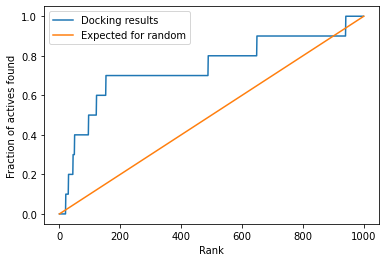

In [75]:
#Do an enrichment plot
%pylab inline
plot( arange(len(hivintegrase_sorted)), hivintegrase_frac_found)
plot( [0, len(hivintegrase_sorted)], [0, 1]) #Random line
legend(('Docking results', 'Expected for random'))
xlabel('Rank')
ylabel('Fraction of actives found')
show()

Using Fred Docking Method

In [73]:
hivintegrase_frac_found_fred,hivintegrase_sorted_fred = docking('./hivint/receptor.pdb','./hivint/crystal_ligand.mol2','Fred',dt_hivint_lingo,'hivint_dock_result_fred.sdf',new_actives)

Populating the interactive namespace from numpy and matplotlib


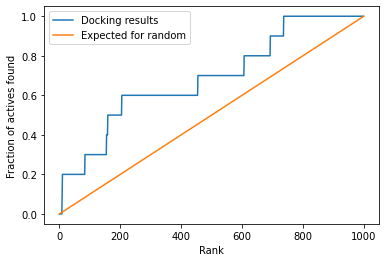

In [76]:
#Do an enrichment plot
%pylab inline
plot( arange(len(hivintegrase_sorted_fred)), hivintegrase_frac_found_fred)
plot( [0, len(hivintegrase_sorted_fred)], [0, 1]) #Random line
legend(('Docking results', 'Expected for random'))
xlabel('Rank')
ylabel('Fraction of actives found')
show()

## Lingo Search with Zinc Compounds - HIV Int

This section explores enrichment of this dataset when additional compounds are added. These compounds are added using the ZINC data base.

In [ ]:
# Tranches. Replace these with your selected tranches
# Compounds selected were in-stock and had an appropriate logP>=5
tranches = "EJAA EJAB EJBA EJBB EJCA EJCB EJEA EJEB FJAA FJAB FJBA FJBB FJCA FJCB FJEA FJEB GJAA GJAB GJBA GJBB GJCA GJCB GJEA GJEB EKAA EKAB EKBA EKBB EKCA EKCB EKEA EKEB FKAA FKAB FKBA FKBB FKCA FKCB FKEA FKEB GKAA GKAB GKBA GKBB GKCA GKCB GKEA GKEB"

In [ ]:
# Split up the string of tranches into a list
tranches_elements = tranches.split()

# Set up an output file and list for storing results
filename = 'zinc_compounds_hivint.smi'
out_file = open(filename, 'w')
zinc_compounds = []

# Loop over SMILES string files for desired tranches 
import urllib
for t_id in tranches_elements:
    prefix = t_id[0:2]
    # Retrieve file-like object for iterating over contents of this one
    contents = urllib.request.urlopen('http://files.docking.org/2D/' + prefix + '/'+ t_id +'.smi')
    # Loop over each line, decode from bytes format to string, write to output. Skip the first line of each file
    # which is a header line
    for line in contents:
        if line.split()[0].decode() != 'smiles':
            # Replace some special characters at the same time
            out_file.write(line.decode().replace('\n',''))
            zinc_compounds.append(line.decode().replace('\r\n',''))
            
out_file.close()

In [77]:
zinc_hivint_names = []
zinc_hivint_smiles = []
with open('zinc_compounds_hivint.smi') as file:
    for line in file:
        name = line.split()[1]
        smiles = line.split()[0]
        zinc_hivint_names.append(name)
        zinc_hivint_smiles.append(smiles)    

In [78]:
dt_hivintegrase_zinc = pd.DataFrame()
dt_hivintegrase_zinc['names'] = actives_names+decoys_names+zinc_hivint_names
dt_hivintegrase_zinc['smiles'] =  actives_smiles+decoys_smiles+zinc_hivint_smiles

In [79]:
lingo_search(dt_hivintegrase_zinc,'hivintegrase_dude_zinc.pickle','hivintegrase_dude_zinc.txt',query_molecule)
df_hivintegrase_lingo_enrivhment_zinc = get_enrichment_score('hivintegrase_dude_zinc.txt','./hivint/actives_final.ism')

229450


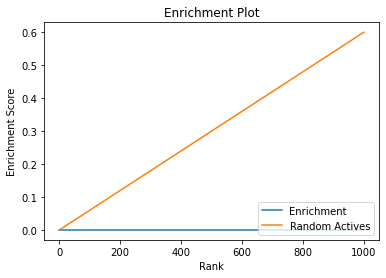

In [80]:
import matplotlib.pyplot as plt
fig1,ax1 = plt.subplots()
ax1.plot(df_hivintegrase_lingo_enrivhment_zinc['ranks'],df_hivintegrase_lingo_enrivhment_zinc['Fraction_of_binders'],label='Enrichment')
ax1.plot(df_hivintegrase_lingo_enrivhment_zinc['ranks'],df_hivintegrase_lingo_enrivhment_zinc['Random_Actives'],label='Random Actives')
plt.xlabel("Rank")
plt.ylabel("Enrichment Score")
plt.title("Enrichment Plot")
plt.legend(loc="lower right")

# DUD-E HIV Reverse Transcriptase Example

In [81]:
# Your code goes here
with open('./hivrt/actives_final.ism', 'r') as file_in:
    actives_names = []
    actives_smiles=[]
    for line in file_in:
        smiles = line.split(' ')[0]
        name = line.split(' ')[2]
        names = name.strip('\n')
        actives_names.append(names)
        actives_smiles.append(smiles)

In [82]:
with open('./hivrt/decoys_final.ism', 'r') as file_in:
    decoys_names = []
    decoys_smiles=[]
    for line in file_in:
        smiles = line.split(' ')[0]
        name = line.split(' ')[1]
        names = name.strip('\n')
        decoys_names.append(names)
        decoys_smiles.append(smiles)

In [83]:
dt_hivrt = pd.DataFrame()
dt_hivrt['names'] = actives_names+decoys_names
dt_hivrt['smiles'] =  actives_smiles+decoys_smiles

## Lingo Search-HIV RT

In [84]:
istream = oemolistream('./hivrt/crystal_ligand.mol2')
mol = OEMol()
OEReadMolecule(istream,mol)
istream.close()
query_molecule = OECreateIsoSmiString(mol)

In [85]:
lingo_search(dt_hivrt,'hivrte_dude.pickle','hivrt_dude.txt',query_molecule)
df_hivrt_lingo_enrichment = get_enrichment_score('hivrt_dude.txt','./hivrt/actives_final.ism')

19217


In [86]:
print(df_hivrt_lingo_enrichment)

     ranks  Fraction_of_binders  Random_Actives
0        1             0.002959        0.000000
1        2             0.005917        0.000601
2        3             0.005917        0.001201
3        4             0.005917        0.001802
4        5             0.005917        0.002402
..     ...                  ...             ...
995    996             0.171598        0.597598
996    997             0.171598        0.598198
997    998             0.171598        0.598799
998    999             0.171598        0.599399
999   1000             0.171598        0.600000

[1000 rows x 3 columns]


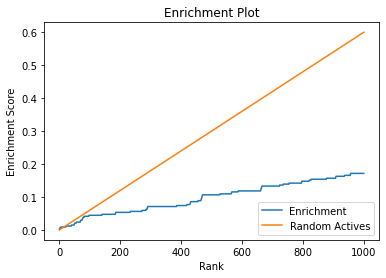

In [87]:
import matplotlib.pyplot as plt
fig1,ax1 = plt.subplots()
ax1.plot(df_hivrt_lingo_enrichment['ranks'],df_hivrt_lingo_enrichment['Fraction_of_binders'],label='Enrichment')
ax1.plot(df_hivrt_lingo_enrichment['ranks'],df_hivrt_lingo_enrichment['Random_Actives'],label='Random Actives')
plt.xlabel("Rank")
plt.ylabel("Enrichment Score")
plt.title("Enrichment Plot")
plt.legend(loc="lower right")

## Docking HIV-RT

Using Hybrid Docking Method

In [91]:
new_actives_hivrt={}
names_lingo=[]
smiles_lingo=[]
dt_hivrt_lingo = pd.DataFrame(columns=['names','smiles'])
with open('hivrt_dude.txt') as file:
    for line in file:
        names = line.split()[1]
        smiles = line.split()[0]
        names_lingo.append(names)
        smiles_lingo.append(smiles)
        if names in actives_names:
            new_actives_hivrt[names]=smiles
dt_hivrt_lingo['names'] = names_lingo
dt_hivrt_lingo['smiles']=smiles_lingo

In [92]:
hivrt_frac_found,hivrt_sorted = docking('./hivrt/receptor.pdb','./hivrt/crystal_ligand.mol2','Hybrid',dt_hivrt_lingo,'hivrt_dock_result.sdf',new_actives_hivrt)

Populating the interactive namespace from numpy and matplotlib


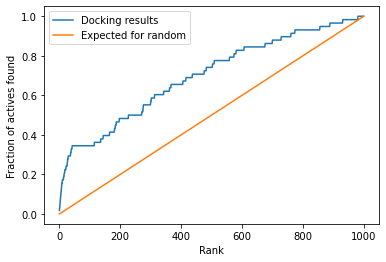

<Figure size 432x288 with 0 Axes>

In [94]:
#Do an enrichment plot
%pylab inline
plot( arange(len(hivrt_sorted)), hivrt_frac_found)
plot( [0, len(hivrt_sorted)], [0, 1]) #Random line
legend(('Docking results', 'Expected for random'))
xlabel('Rank')
ylabel('Fraction of actives found')
show()
savefig( 'docking-results-enrichment-hivint.pdf')

Using Fred Docking Method

In [95]:
hivrt_frac_found_fred,hivrt_sorted_fred = docking('./hivrt/receptor.pdb','./hivrt/crystal_ligand.mol2','Fred',dt_hivrt_lingo,'hivint_dock_result_fred.sdf',new_actives_hivrt)

Populating the interactive namespace from numpy and matplotlib


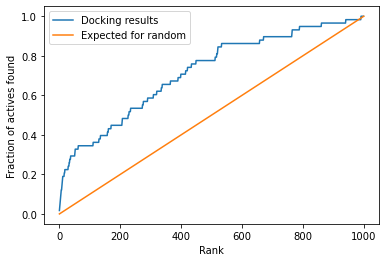

<Figure size 432x288 with 0 Axes>

In [96]:
#Do an enrichment plot
%pylab inline
plot( arange(len(hivrt_sorted_fred)), hivrt_frac_found_fred)
plot( [0, len(hivrt_sorted_fred)], [0, 1]) #Random line
legend(('Docking results', 'Expected for random'))
xlabel('Rank')
ylabel('Fraction of actives found')
show()

### Lingo Search with Zinc Compounds - HIV RT

I have used the same ZINC compounds for the HIV RT as the HIV Integrase.

In [98]:
dt_hivrt_zinc = pd.DataFrame()
dt_hivrt_zinc['names'] = actives_names+decoys_names+zinc_hivint_names
dt_hivrt_zinc['smiles'] =  actives_smiles+decoys_smiles+zinc_hivint_smiles

In [99]:
lingo_search(dt_hivintegrase_zinc,'hivrt_dude_zinc.pickle','hivrt_dude_zinc.txt',query_molecule)
df_hivintegrase_lingo_enrivhment_zinc = get_enrichment_score('hivintegrase_dude_zinc.txt','./hivint/actives_final.ism')

229450


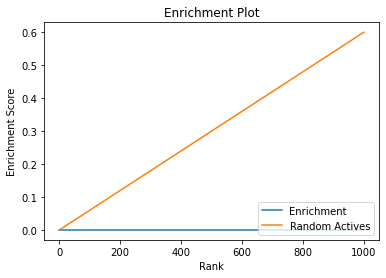

In [100]:
fig1,ax1 = plt.subplots()
ax1.plot(df_hivintegrase_lingo_enrivhment_zinc['ranks'],df_hivintegrase_lingo_enrivhment_zinc['Fraction_of_binders'],label='Enrichment')
ax1.plot(df_hivintegrase_lingo_enrivhment_zinc['ranks'],df_hivintegrase_lingo_enrivhment_zinc['Random_Actives'],label='Random Actives')
plt.xlabel("Rank")
plt.ylabel("Enrichment Score")
plt.title("Enrichment Plot")
plt.legend(loc="lower right")

## Consider some questions

- Why does LINGO do so well here, at least in your initial test above? (Hint: Note who produced the 3NF8 structure by looking it up on the PDB. Is this part of the same series as the SAMPL4 ligands? Do you find that typical ZINC compounds bear a strong resemblance to these, or not?)
- You might be interested in looking at physical properties (size, number of rotatable bonds, polarity, etc.) of the LINGO matches to see how they compare to the SAMPL4 ligands; if so, feel free to ask if you need any help figuring out how to calculate those properties using the OpenEye tools.
- Which of the docking scoring functions you tried performs best? Do any of them perform better than random in the second example above?
- If you try docking on the results of a LINGO search — does it do any further enrichment? How does this depend on the database you dock? If you are docking compounds from ZINC, can you be sure the enrichment (or lack thereof) is real? (Hint: Do you know the compounds from ZINC are inactive?)
- If you compare results of a single method (i.e. docking) on several different databases or targets, comment on how the contents of the database, or the target you are working on, impacts performance. If possible, speculate as to why.

## Write a brief report below (or separately) for submission

Submit a brief report explaining what you did along with key plots you generated, either in this notebook or as a separate file uploaded to Canvas. Explain what you think your results mean, and answer any of the above questions you are able to. The key idea here is really to do three things:
- Explain what you did and show me the results
- Tell me what you learned and what you thought was interesting. This should include commenting on how much enrichment depends on the data set you examine and what scoring function you use. 
- Point out anything which is particularly helpful in understanding strengths and weaknesses of docking and LINGO and how they might work together.
- Also attach all enrichment plots you are reporting on, including the one you were assigned in Warm-Up Part 2

In the above cells, I have utilized two datasets related to HIV-inhibitorase and HIV-reverse transcriptase which I acquired from DUD-E data base. For each of these datasets, I first perform `LINGO` search to find the top 1000 compounds to the query ligand using the `LINGO` similarity search and then perform docking on these compounds. There are two methods of molecular docking that I am utilizing here- 1. `Hybrid` and the 2. `Fred` that utilize `Chemical Gaussian Overaly` and `Chemgauss` exhaustive searches in the `Openeye Toolkit`. To streamline my sandbox experiments, I have written functions to reduce the number of lines of code required and a description of the functions can be found in the [Functions](#Functions) section. 

First I would like to discuss the example of the HIV-integrase with SAMPL4 actives and then with the DUD-E dataset. The performance of `LINGO Search` and `Docking` were much better with the SAMPL4 actives when compared to that of the DUD-E dataset. This can be attributed to the fact that the DUD-E dataset contains decoys that are similar to the actives but come from different chemical classes. The SAMPL4 actives originate from the same chemical class and hence both `LINGO Search` and `Docking` do a better job in finidng actives than compared to actives and decoys from the DUD-E dataset.

Next, I was interested to look at combining the actives and decoys from DUD-E with decoys from ZINC to expand the chemical space and further test the capabilities of the `LINGO Search` algorithm. I found that the performance of the `LINGO Search` algorithm seemed to be awful when additional ZINC compounds were added to the dataset, this might be becuase the compounds are random and additionally its difficult to find actives related to targets on ZINC which would have further reduced the performance. As can be seen from the graphs above, the enrichment is nearly Zero with the `LINGO Search` after the addition of the ZINC compounds. I was interested in picking more appropriate ZINC compounds, to elaborate based on having similar chemical properties such as logP, following Lipinki's rule of 5 (MW<500) and also being commercially avaialble. However, it would seem that the `LINGO Search` did not perform very well, which would mean it found a lot of compounds from the ZINC database that were similar to the ligand but there was no method of identifying whether these were actives which my have punished its performance. The enrchiment plot for the HIV RT DUD-E database can be found in the [DUD-E HIV Reverse Transcriptase Example](#Lingo-Search-with-Zinc-Compounds---HIV-RT) and the one for the [DUD-E HIV Integrase](#Lingo-Search-with-Zinc-Compounds---HIV-Int)

It would seem that the enrichment scores were improved for docking methods after having first filtered out the compounds using the `LINGO Search`, this was tested for only the DUD-E data and not for the SAMPL4 actives, though given the performance of the `LINGO Search` on that dataset, the docking scores would have definitely imporved. As far as the example of the [HIV Integrase Example](#DUD-E-HIV-Integrase-Example), the enrichment plots for docking can be found in the [Docking-HIV int](#Docking---HIV-Int) section, the enrichment is much better after utilizing compounds selected by `LINGO Search`. Additionally, using a list of actives that were present in the selected compounds from the `LINGO Search` as compared to the entire list of actives offers a better performance indicator of docking without penalizing the algorithm for not containing all of the original actives. In this case the Hybrid method slightly outperforms the Fred method. In the case of [HIV Reverse Transcriptase Example](#DUD-E-HIV-Reverse-Transcriptase-Example), both methods demonstrate similar performance, see [HIV RT Docking](#Docking-HIV-RT) for enrichment plots. This demonstrates that docking performance is dependent on the ligand structure and the data set being utilized. Performance on the SAMPL4 actives and decoys data was quite similar between both methods, this dataset had more poor performance for docking compared to the DUD-E HIV integrase example, but this is again because the results of the `LINGO Search` were not used for docking.

